In [37]:
import boto3
import io
import pandas as pd

import seaborn as sns

import datetime as dt

import numpy as np 
import matplotlib
import matplotlib.ticker as ticker
from matplotlib import transforms, pyplot as plt
%matplotlib inline

In [2]:
boto3.setup_default_session(profile_name='personal')

# Input data checks
List the files available to work with

In [3]:
client = boto3.client('s3')
response = client.list_objects_v2(
    Bucket='prj001-baby',
    #Delimiter='/',
    EncodingType='url',
    MaxKeys=123,
    #Prefix='raw',
    #ContinuationToken='string',
    #FetchOwner=True|False,
    StartAfter='data/001/raw',
    #RequestPayer='requester'
)
#print(response)
for o in response.get('Contents'):
    print (o.get('Key') + ' ' + str(o.get('Size')/ 1000) + ' kb' )
    

data/001/raw/ 0.0 kb
data/001/raw/excretions.csv 54.392 kb
data/001/raw/feeds.csv 219.83 kb
data/001/raw/growths.csv 0.064 kb
data/001/raw/journal_entries.csv 1.209 kb
data/001/raw/medicine_records.csv 0.347 kb
data/001/raw/medicines.csv 0.171 kb
data/001/raw/pauses.csv 0.47 kb
data/001/raw/pumpings.csv 0.171 kb
data/001/raw/sleeps.csv 2.662 kb
data/001/raw/teeths.csv 0.033 kb
data/001/raw/temperatures.csv 0.045 kb
data/001/raw/vaccinations.csv 0.166 kb


# Changes data

Read in raw data

In [4]:
boto3.setup_default_session(profile_name='personal')
s3 = boto3.client('s3')
obj = s3.get_object(Bucket='prj001-baby', Key='data/001/raw/excretions.csv')
df = pd.read_csv(io.BytesIO(obj['Body'].read()))

Always add a row number to preserve original data order

In [5]:
df['row_num'] = np.arange(len(df))+1
df.shape

(1647, 5)

Inspect the columns used. 
Most column names have been prefixed with a space

In [6]:
df.columns

Index(['id', ' Time', ' Type', ' Notes', 'row_num'], dtype='object')

There are some odd feed durations. I left the stopwatch running because I was sleep deprived

In [7]:
df.describe()

,id,row_num
count,1647.000000,1647.000000
mean,835.376442,824.000000
std,481.004626,475.592262
min,3.000000,1.000000
25%,417.500000,412.500000
50%,836.000000,824.000000
75%,1251.500000,1235.500000
max,1668.000000,1647.000000


In [8]:
print('Rows: ' + str(df.shape[0]) )

Rows: 1647


In [9]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1647 entries, 0 to 1646
Data columns (total 5 columns):
id         1647 non-null int64
 Time      1647 non-null object
 Type      1647 non-null object
 Notes     66 non-null object
row_num    1647 non-null int64
dtypes: int64(2), object(3)
memory usage: 64.4+ KB
None


## Changes are in reverse order in the data

In [10]:
df.head(5)

,id,Time,Type,Notes,row_num
0,1668,13:03:37 03-04-2018,Pee and Poo,NaN,1
1,1667,07:37:59 03-04-2018,Poo,NaN,2
2,1666,16:02:38 03-03-2018,Pee,NaN,3
3,1665,11:48:23 03-03-2018,Pee,NaN,4
4,1664,07:23:01 03-02-2018,Pee and Poo,NaN,5


## Time range of feeds 

In [11]:
df[' Time'] = df[' Time'].astype('datetime64')

In [12]:
start_date = min(df[' Time'])
end_date = max(df[' Time']) 

The earliest event happens on {{start_date}} 
The final event happens on {{end_date}}

## A small number of change types

In [13]:
df[' Type'].unique()

array(['Pee and Poo', 'Poo', 'Pee', 'Dry Diaper'], dtype=object)

In [14]:
def bins_labels(bins, **kwargs):
    '''Create a properly aligned set of bin ticks for a distplot
    
    Args:
        bins : range describing the bins

    Raises:

    Returns:
    '''
    bin_w = (max(bins) - min(bins)) / (len(bins) - 1)
    plt.xticks(np.arange(min(bins)+bin_w/2, max(bins), bin_w), bins, **kwargs)
    plt.xlim(bins[0], bins[-1])

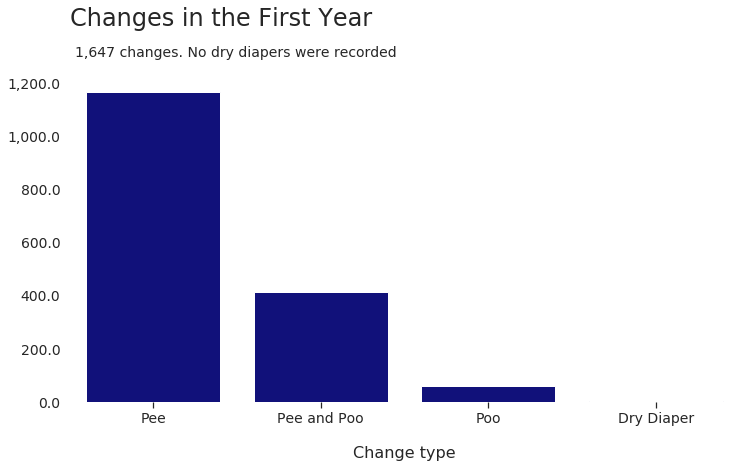

In [43]:
sns.set_style('whitegrid')

# configure plot font family to Arial
#plt.rcParams['font.family'] = 'Arial'
matplotlib.rcParams['mathtext.bf'] = 'Arial:bold'
matplotlib.rcParams['mathtext.it'] = 'Arial:italic'


sns.set(rc={'figure.figsize':(12,6),
            'axes.facecolor':'white', 
            'figure.facecolor':'white'})

plot_order = df[' Type'].value_counts().index
ax = sns.countplot(df[' Type'] ,
                   color = 'darkblue',
                   order = plot_order
                  )


#ax.set(xticks=np.arange(0,max_quantity,25))

# Grids and lines
ax.xaxis.grid() # remove vertical grid
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

# X axis
#bins_labels(bins)
ax.tick_params(bottom='on')
ax.set_xlabel('Change type',fontsize=16)
ax.xaxis.labelpad = 20

for item in ax.get_xticklabels():
    item.set_fontsize(14)

    
# Y Axis
for item in ax.get_yticklabels():
    item.set_fontsize(14)
ax.set_ylabel('',fontsize=14)
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos:'{:,}'.format(x)))

# Titles
ax.set_title('Changes in the First Year'
             , pad=50
             , fontsize=24
             , loc='left')


ax.annotate('{:,}'.format(len(df)) + " changes. "
            + "No dry diapers were recorded", 
            xy=(0,1), 
            xycoords="axes fraction",
            xytext=(5,30), 
            textcoords="offset points",
            ha="left", va="top",
            fontsize=14)

plt.show()

# Pattern of Change Types Across the year

In [16]:
df.head(3)

,id,Time,Type,Notes,row_num
0,1668,2018-03-04 13:03:37,Pee and Poo,NaN,1
1,1667,2018-03-04 07:37:59,Poo,NaN,2
2,1666,2018-03-03 16:02:38,Pee,NaN,3


Derive new columns to visualize events using
* month and week of the year 
* time stamp of when event occured
* whether event was during the night or day

In [17]:
df['time_yymmww_cln'] = df[' Time'].map(lambda x: str(x.year) + '-' + str(x.month).zfill(2) + '-' + str(x.week).zfill(2) )
df['time_yymmdd_cln'] = df[' Time'].map(lambda x: str(x.year) + '-' + str(x.month).zfill(2) + '-' + str(x.day).zfill(2) )

df['time_cln'] = df[' Time'].dt.time
df['time_hr_cln'] = df[' Time'].dt.hour
df.head(5)

,id,Time,Type,Notes,row_num,time_yymmww_cln,time_yymmdd_cln,time_cln,time_hr_cln
0,1668,2018-03-04 13:03:37,Pee and Poo,NaN,1,2018-03-09,2018-03-04,13:03:37,13
1,1667,2018-03-04 07:37:59,Poo,NaN,2,2018-03-09,2018-03-04,07:37:59,7
2,1666,2018-03-03 16:02:38,Pee,NaN,3,2018-03-09,2018-03-03,16:02:38,16
3,1665,2018-03-03 11:48:23,Pee,NaN,4,2018-03-09,2018-03-03,11:48:23,11
4,1664,2018-03-02 07:23:01,Pee and Poo,NaN,5,2018-03-09,2018-03-02,07:23:01,7


In [18]:
start_of_day = 6
end_of_day = 23

conditions = [
    (df['time_hr_cln'] <= start_of_day) | (df['time_hr_cln'] >= end_of_day)]
choices = ['night']
df['time_of_day'] = np.select(conditions, choices, default='day')

In [19]:
df_tmp=df
df_tmp.sort_values('time_yymmww_cln', ascending=True, inplace=True)
df_tmp.head(5)

,id,Time,Type,Notes,row_num,time_yymmww_cln,time_yymmdd_cln,time_cln,time_hr_cln,time_of_day
1646,3,2017-04-26 07:33:17,Pee and Poo,NaN,1647,2017-04-17,2017-04-26,07:33:17,7,day
1623,28,2017-04-30 23:01:38,Pee,NaN,1624,2017-04-17,2017-04-30,23:01:38,23,night
1624,27,2017-04-30 19:11:19,Pee,NaN,1625,2017-04-17,2017-04-30,19:11:19,19,day
1625,26,2017-04-30 14:16:13,Pee and Poo,NaN,1626,2017-04-17,2017-04-30,14:16:13,14,day
1626,23,2017-04-30 07:30:19,Pee,NaN,1627,2017-04-17,2017-04-30,07:30:19,7,day


## Visualize change times

### Timing of changes

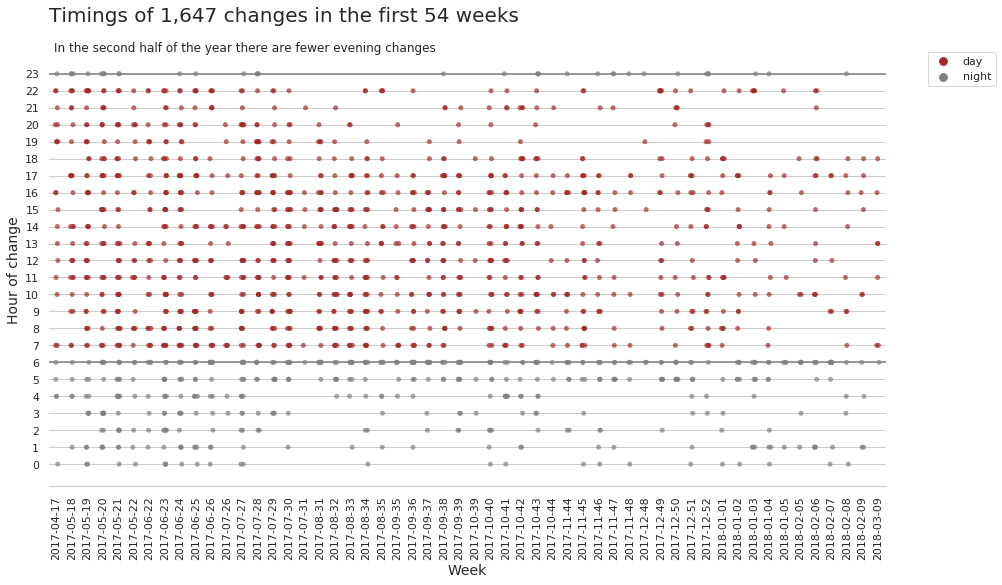

In [21]:
sns.set(rc={'figure.figsize':(15,8)})
sns.set_style('whitegrid')
 
# Fonts
plt.rcParams['font.family'] = 'Arial'
matplotlib.rcParams['mathtext.bf'] = 'Arial:bold'
matplotlib.rcParams['mathtext.it'] = 'Arial:italic'

hue_palette ={"night":"gray","day":"brown"}


ax = sns.stripplot(
    x="time_yymmww_cln", 
    y="time_hr_cln", 
    hue='time_of_day',
    jitter=True,
    alpha = 0.7,
    palette=hue_palette,
    data=df_tmp)

# Grids and lines
sns.set_style('whitegrid')
ax.spines['right'].set_visible(False)
sns.despine(left=True,right=True)

# X axis labels
ax.set_xlabel('Week',fontsize=14)
for item in ax.get_xticklabels():
    item.set_rotation(90)

# Y axis labels
ax.set_ylabel('Hour of change',fontsize=14)
ax.set(yticks=np.arange(start=0,stop=24,step=1))


# Titles
ax.set_title('Timings of '+ '{:,}'.format(len(df_tmp)) +' changes in the first '
             + str(df_tmp['time_yymmww_cln'].nunique())+ ' weeks', 
             pad=30, fontsize=20,loc='left')

ax.annotate("In the second half of the year there are fewer evening changes", 
            xy=(0,1), 
            xycoords="axes fraction",
            xytext=(5,10), 
            textcoords="offset points",
            ha="left", va="top",
            fontsize=12)

# Some lines to highlight things
plt.axhline(y=end_of_day, color='gray', linestyle='-')
plt.axhline(y=start_of_day, color='gray', linestyle='-')

# Legends and annotations
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.show()

### Number of changes

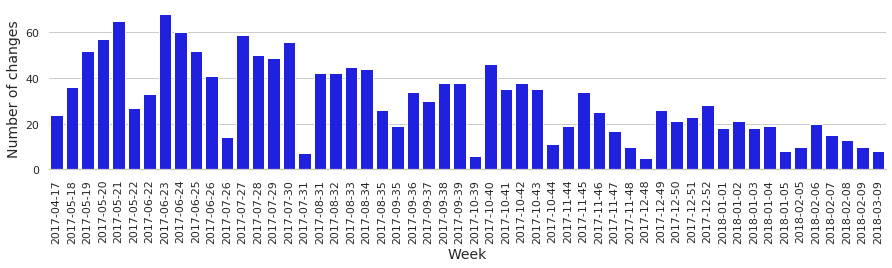

In [22]:
sns.set(rc={'figure.figsize':(15,3)})
sns.set_style('whitegrid')
 
ax2 = sns.countplot(x="time_yymmww_cln",color='blue', data=df_tmp)

# Grids and lines
sns.set_style('whitegrid')
ax2.spines['right'].set_visible(False)
sns.despine(left=True,right=True)

# X axis labels
ax2.set_xlabel('Week',fontsize=14)
for item in ax2.get_xticklabels():
    item.set_rotation(90)

# Y axis labels
ax2.set_ylabel('Number of changes',fontsize=14)
#ax.set(yticks=np.arange(start=0,stop=24,step=1))

plt.show()